# Imports

* Será utilizado a biblioteca Keras para o desenvolvimento do modelo de classificação.

* A bilioteca Pandas será utilizado para manipular os dados

In [1]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

2023-09-16 17:00:19.042202: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-16 17:00:19.646062: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Leitura Dataset

O dataset escolhido foi o [FER-2013](https://www.kaggle.com/datasets/msambare/fer2013) disponível no Kaggle. O dataset constitue-se de imagens de 48x48 pixels em escala de cinza representando expressões faciais humanas em 7 classes rotuladas, sendo elas: Angry, Disgust, Fear, Happy, Sad, Surprise e Neutral.

In [2]:
# Caminho para os arquivos de treino e validação
train_dir = '../data/fear2013/csv/train_pixels_data.csv'
valid_dir = '../data/fear2013/csv/test_pixels_data.csv'

# Resolução das imagens
image_size = (48, 48)
# Escala de cores da imagem
color_mode = 'grayscale'

In [3]:
# Função para padronizar a leitura dos dados
def read_dataset(path):
    data = pd.read_csv(
        path,
    )
    return data

In [4]:
# Leitura do conjunto de treino e validação
df_train = read_dataset(train_dir)
df_valid = read_dataset(valid_dir) 

# Visualização dos Dados

In [5]:
# Função para plotar a distribuição de classes
def plot_class_distribution(df):
    
    df['label'].value_counts().plot.bar()

In [6]:
# Função para plotar 3 exemplos de cada classe alvo
def plot_examples(df):   
    fig = plt.figure(figsize=(10, 10))
    n_classes = df['label'].nunique()
    
    for i, (label, group_df) in enumerate(df.groupby('label')):
        samples = group_df.sample(3, random_state=42)
        
        for j, (_, row) in enumerate(samples.iterrows()):
            ax = fig.add_subplot(3, n_classes, i + j*n_classes + 1) # i*3 + j + 1
            
            image_data = np.array(row[1:]).reshape(image_size).astype('uint8')
            plt.imshow(image_data, cmap='gray')
            
            ax.set_title(label)
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

* Verificando as linhas do conjunto de treino

In [7]:

df_train.head()

,label,0,1,2,3,4,5,6,7,8,...,2294,2295,2296,2297,2298,2299,2300,2301,2302,2303
0,angry,50,32,15,11,12,10,10,8,15,...,160,157,156,152,148,151,141,143,136,83
1,angry,29,24,29,11,15,22,26,11,7,...,60,109,165,148,75,49,33,15,24,24
2,angry,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,angry,155,138,98,112,94,97,111,107,101,...,102,97,95,92,94,101,108,111,112,109
4,angry,211,215,220,221,219,216,213,210,207,...,171,170,168,162,170,169,160,159,156,152


* Plotando a distribuição de classes do conjunto de treino

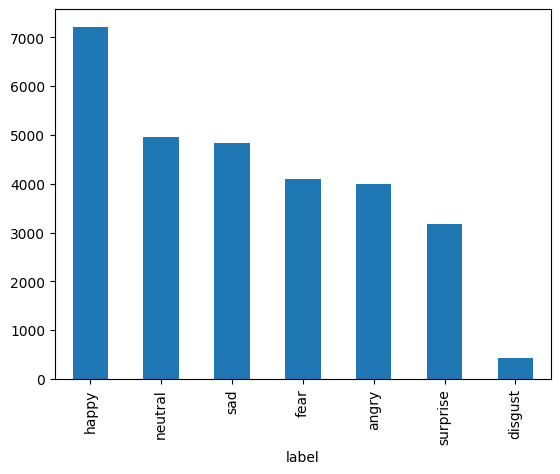

In [8]:
plot_class_distribution(df_train)

* Plotando a distribuição do conjunto de validação

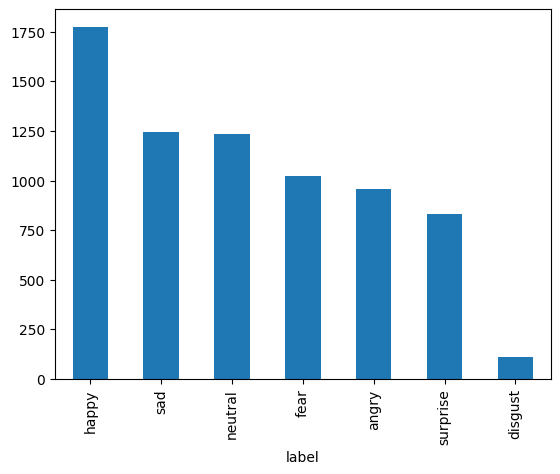

In [9]:
plot_class_distribution(df_valid)

* Plotando 3 exemplos de cada classe. Cada classe está em uma coluna da imagem.

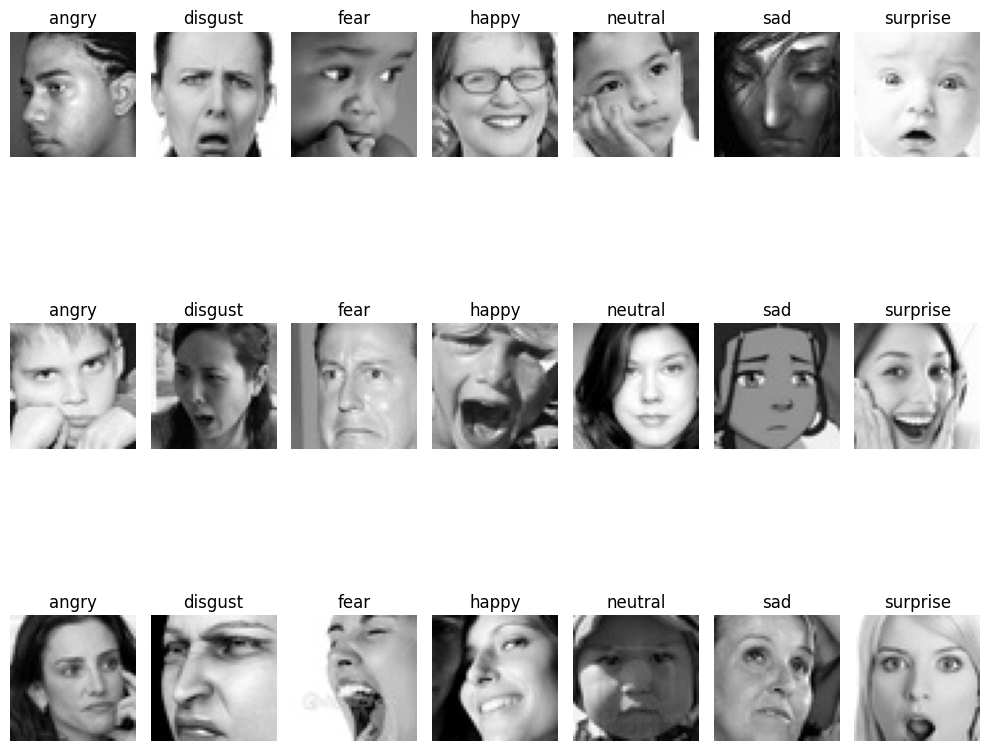

In [10]:
plot_examples(df_train)

# Separação dos Alvo e Features

* Separação das features e do target do conjunto de treino e teste

In [11]:
x_train = df_train.iloc[:, 1:].values
y_train = df_train['label']

x_valid = df_valid.iloc[:, 1:].values
y_valid = df_valid['label']


* Verificação das classes contidas em cada conjunto


In [12]:
y_train.unique(), y_valid.unique()

(array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
       dtype=object),
 array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
       dtype=object))

* Verificando dimensões resultantes

In [13]:
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [14]:
x_valid.shape, y_valid.shape

((7178, 2304), (7178,))

# Pré-processamento 

Etapa de pré-processamento das features dos dados

## Normalização

Normalização dos píxels das imagens para assumir o valor entre 0 e 1

In [15]:
x_train.min(), x_train.max()

(0, 255)

In [16]:
x_valid.min(), x_valid.max()

(0, 255)

In [17]:
x_train = x_train / x_train.max()
x_valid = x_valid / x_valid.max()

# Categorização das classes

É criado uma representação one-hot para as classes alvo.

Como as classes estão em string utilizou-se o pd.get_dummies em vez do keras.utils.to_categorical.

In [18]:
num_classes = y_train.nunique()
classes = y_train.unique()

y_train = pd.get_dummies(y_train, dtype='uint8')
y_valid = pd.get_dummies(y_valid, dtype='uint8')

* Verificando ordenamento da representação one-hot

In [19]:
y_train

,angry,disgust,fear,happy,neutral,sad,surprise
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
28704,0,0,0,0,0,0,1
28705,0,0,0,0,0,0,1
28706,0,0,0,0,0,0,1
28707,0,0,0,0,0,0,1


In [20]:
y_valid

,angry,disgust,fear,happy,neutral,sad,surprise
0,1,0,0,0,0,0,0
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
7173,0,0,0,0,0,0,1
7174,0,0,0,0,0,0,1
7175,0,0,0,0,0,0,1
7176,0,0,0,0,0,0,1


* Como esperado o ordenamento das classes é o mesmo para os dois conjuntos de dados. Logo, é retirado somente os valores das linhas.

In [21]:
y_train = y_train.values
y_valid = y_valid.values

* Verificando o novo shape

In [22]:
y_train.shape, y_valid.shape

((28709, 7), (7178, 7))

# Construção do Modelo

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [24]:
# Foi construído um modelo com duas escondidas e a camada de saída com 7 unidades, um para classe 
model = Sequential()
model.add(Dense(units=512, activation='relu', input_shape=(x_train.shape[1],)))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=num_classes, activation='softmax'))

2023-09-16 17:00:26.547797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 17:00:26.565386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-16 17:00:26.565517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Visualização do Modelo

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1180160   
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 1446407 (5.52 MB)
Trainable params: 1446407 (5.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* Plotando o model

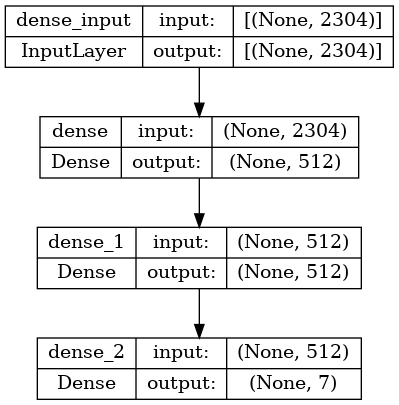

In [25]:
keras.utils.plot_model(model, show_shapes=True)

No plot podemos visualizar a camada de entrada seguida por duas camadas escondidas e a camada de saída

## Compilando o modelo

* Para a loss foi utilizado 'categorical_crossentropy' já que é um problema com multiclasses e o otimizador Adam.

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinando o modelo

* O modelo foi treinado por 100 épocas

In [28]:
model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, verbose=1)

Epoch 1/100


2023-09-16 17:06:29.796943: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-16 17:06:29.824727: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x17d9dd00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-16 17:06:29.824754: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-09-16 17:06:29.877407: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-16 17:06:30.132604: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-16 17:06:30.346581: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

898/898 [==============================] - 5s 2ms/step - loss: 1.7870 - accuracy: 0.2757 - val_loss: 1.6823 - val_accuracy: 0.3363
Epoch 2/100
898/898 [==============================] - 2s 2ms/step - loss: 1.6864 - accuracy: 0.3351 - val_loss: 1.6422 - val_accuracy: 0.3675
Epoch 3/100
898/898 [==============================] - 1s 2ms/step - loss: 1.6639 - accuracy: 0.3452 - val_loss: 1.6553 - val_accuracy: 0.3484
Epoch 4/100
898/898 [==============================] - 2s 2ms/step - loss: 1.6520 - accuracy: 0.3514 - val_loss: 1.6593 - val_accuracy: 0.3592
Epoch 5/100
898/898 [==============================] - 2s 2ms/step - loss: 1.6433 - accuracy: 0.3552 - val_loss: 1.6291 - val_accuracy: 0.3660
Epoch 6/100
898/898 [==============================] - 2s 2ms/step - loss: 1.6391 - accuracy: 0.3591 - val_loss: 1.6368 - val_accuracy: 0.3654
Epoch 7/100
898/898 [==============================] - 2s 2ms/step - loss: 1.6328 - accuracy: 0.3625 - val_loss: 1.6167 - val_accuracy: 0.3732
Epoch 8/100

# Avaliação

## Matriz de confusão

* Predição do modelo do label do conjunto de validação

In [29]:
# é feito argmax para pegar o índice que identifica a classe com maior probabilidade de ser a classe real segundo o modelo.
y_valid_pred = model.predict(x_valid).argmax(axis=1)

225/225 [==============================] - 0s 670us/step


* Criado a matriz de confusão para avaliar o modelo no conjunto de validação

In [30]:
cm = confusion_matrix(y_valid.argmax(axis=1), y_valid_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                            display_labels=classes)

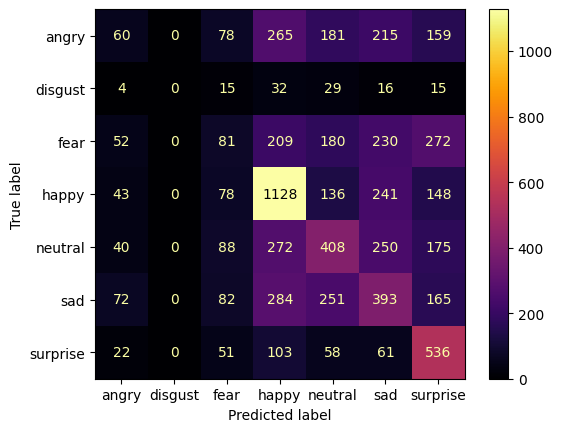

In [31]:
disp.plot(cmap='inferno')

Vemos que o modelo teve uma performance melhor em algumas classes do que outras, mas no geral a matriz de confusão está bem esparsa, não concentrando os valores na diagonal principal, e assim apresentando uma performance fraca.

## Métricas de avaliação: Acurácia, Precisão, Recall e F1-Score

* Print das métricas de avaliação

In [32]:
print(classification_report(y_valid.argmax(axis=1), y_valid_pred, target_names=classes))

              precision    recall  f1-score   support

       angry       0.20      0.06      0.10       958
     disgust       0.00      0.00      0.00       111
        fear       0.17      0.08      0.11      1024
       happy       0.49      0.64      0.55      1774
     neutral       0.33      0.33      0.33      1233
         sad       0.28      0.32      0.30      1247
    surprise       0.36      0.65      0.47       831

    accuracy                           0.36      7178
   macro avg       0.26      0.30      0.26      7178
weighted avg       0.32      0.36      0.33      7178



/home/matheusalb/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matheusalb/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/matheusalb/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

## Comentários Avaliação

O modelo construído não apresentou bom desempenho nem no conjunto de treino nem no conjunto de validação. Embora sua acurácia tenha sido superior à de uma escolha aleatória (14,3%), o valor de 36% ainda é consideravelmente baixo, sugerindo que o modelo sofreu de underfitting devido a baixa complexidade do modelo construído.

No conjunto de validação, observamos que o modelo não previu a classe "disgust" em nenhum dos casos. Isso provavelmente ocorre devido ao número limitado de exemplos de treino para essa classe. Comparando com outras classes, o modelo pode ter priorizado aquelas com maior número de exemplos para reduzir o erro global.